In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

## Data Preprocessing

In [2]:
TRAINING_DIR = "data/rps/"
VALIDATION_DIR = "data/rps-validation/"

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=126,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 2520 images belonging to 3 classes.


In [4]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=11,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))

Found 33 images belonging to 3 classes.


## Create Model

In [5]:
path_inception = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

local_weights_file = path_inception
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None                               
)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


In [7]:

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
optimizer = tf.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training

In [9]:
epoch = 10
H = model.fit(train_generator,
              steps_per_epoch=20,
              epochs=epoch,
              validation_data=validation_generator,
              validation_steps=3)

Epoch 1/10
20/20 [==============================] - 26s 869ms/step - loss: 0.8170 - accuracy: 0.6415 - val_loss: 0.2473 - val_accuracy: 0.9091
Epoch 2/10
20/20 [==============================] - 15s 765ms/step - loss: 0.1463 - accuracy: 0.9482 - val_loss: 0.1021 - val_accuracy: 0.9394
Epoch 3/10
20/20 [==============================] - 15s 764ms/step - loss: 0.0753 - accuracy: 0.9769 - val_loss: 0.1069 - val_accuracy: 0.9394
Epoch 4/10
20/20 [==============================] - 15s 754ms/step - loss: 0.0432 - accuracy: 0.9870 - val_loss: 0.1662 - val_accuracy: 0.9394
Epoch 5/10
20/20 [==============================] - 15s 761ms/step - loss: 0.0322 - accuracy: 0.9899 - val_loss: 0.1266 - val_accuracy: 0.9394
Epoch 6/10
20/20 [==============================] - 15s 753ms/step - loss: 0.0363 - accuracy: 0.9901 - val_loss: 0.0882 - val_accuracy: 0.9394
Epoch 7/10
20/20 [==============================] - 15s 761ms/step - loss: 0.0310 - accuracy: 0.9916 - val_loss: 0.2360 - val_accuracy: 0.9091

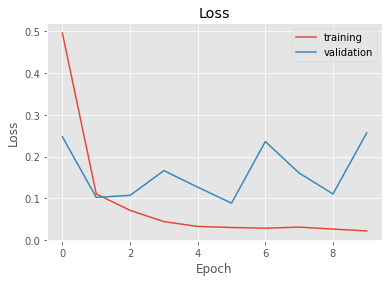

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch), H.history["loss"], label="training")
plt.plot(np.arange(0, epoch), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("images/plot.png")

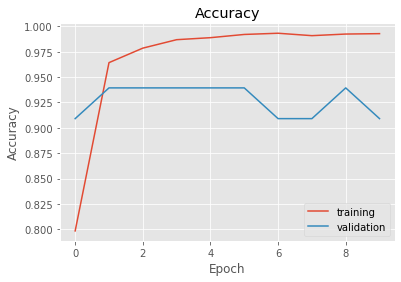

In [11]:
plt.figure()
plt.plot(np.arange(0, epoch), H.history["accuracy"], label="training")
plt.plot(np.arange(0, epoch), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
#plt.savefig("images/plot_acc.png")